In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
import re
from fuzzywuzzy import process


In [2]:
airport_traffic_2016 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2016.csv")
airport_traffic_2017 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2017.csv")
airport_traffic_2018 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2018.csv")
airport_traffic_2019 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2019.csv")
airport_traffic_2020 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2020.csv")
airport_traffic_2021 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2021.csv")
airport_traffic_2022 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2022.csv")
airport_traffic_2023 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2023.csv")
airport_traffic_2024 = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/airport_traffic_2024.csv")

iata_code = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/missing_IATA_codes.csv")
iata_code = iata_code["CAO,IATA"].str.split(',', expand=True)
iata_code = iata_code.rename(columns={0: 'CAO',1:'IATA'})

combined_airport_traffic_df = combined_airport_traffic = pd.concat([airport_traffic_2016, airport_traffic_2017,airport_traffic_2018,airport_traffic_2019,airport_traffic_2020,airport_traffic_2021,airport_traffic_2022,airport_traffic_2023,airport_traffic_2024], ignore_index=True)
taxi_in_df = pd.read_excel("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/Taxi_times_Planning_Data_S14_S22.xlsx",sheet_name="Taxi-In S14-S22")
taxi_out_df = pd.read_excel("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/Taxi_times_Planning_Data_S14_S22.xlsx",sheet_name="Taxi-Out S14-W22")
waketurb_df = pd.read_excel("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/Taxi_times_Planning_Data_S14_S22.xlsx",sheet_name="Wake Turbul. Taxi-out S14-W22")


In [3]:
combined_airport_traffic_df = pd.merge(combined_airport_traffic_df, taxi_in_df[["ICAO","IATA"]], how='left', left_on = "APT_ICAO", right_on="ICAO")
combined_airport_traffic_df = pd.merge(combined_airport_traffic_df, iata_code, how='left', left_on = "APT_ICAO", right_on="CAO")
combined_airport_traffic_df.loc[
    ((combined_airport_traffic_df["IATA_x"].isnull()) &
    (combined_airport_traffic_df["IATA_y"].notnull())),
    "IATA_x"
] = combined_airport_traffic_df["IATA_y"]

combined_airport_traffic_df = combined_airport_traffic_df.rename(columns={"IATA_x":'IATA'})
date_pattern = r'\b\d{4}-(0[1-9]|1[0-2])-(0[1-9]|[12][0-9]|3[01])\b(,\s*\b\d{4}-(0[1-9]|1[0-2])-(0[1-9]|[12][0-9]|3[01])\b)*'
combined_airport_traffic_df ["date_check"] = "other"
combined_airport_traffic_df.loc[
    combined_airport_traffic_df["FLT_DATE"].str.match(date_pattern),
    "date_check"
] = "YYYY-MM-DD"
combined_airport_traffic_df["date_check"].nunique()
combined_airport_traffic_df["FLT_DATE"]  = pd.to_datetime(combined_airport_traffic_df["FLT_DATE"])

combined_airport_traffic_df.drop(columns=["date_check","IATA_y","CAO","ICAO"],inplace = True)
combined_airport_traffic_df.drop_duplicates(inplace = True)

In [4]:
combined_airport_traffic_df["YEAR_MONTH"] = combined_airport_traffic_df['FLT_DATE'].dt.strftime('%Y-%m')
columns_moved = ["YEAR","MONTH_NUM","MONTH_MON","FLT_DATE","YEAR_MONTH"]
new_order = columns_moved + [column for column in combined_airport_traffic_df.columns if column not in columns_moved]
combined_airport_traffic_df = combined_airport_traffic_df[new_order]

In [5]:
spanish_departures = combined_airport_traffic_df.loc[combined_airport_traffic_df["STATE_NAME"]=='Spain',["YEAR","YEAR_MONTH","APT_NAME","IATA","FLT_DEP_1"]]
spanish_arrivals = combined_airport_traffic_df.loc[combined_airport_traffic_df["STATE_NAME"]=='Spain',["YEAR","YEAR_MONTH","APT_NAME","IATA","FLT_ARR_1"]]
spanish_arrivals_flights = combined_airport_traffic_df.loc[combined_airport_traffic_df["STATE_NAME"]=='Spain',["YEAR","YEAR_MONTH","APT_NAME","IATA","FLT_TOT_1"]]


In [6]:
airport_taxes_df = pd.read_excel("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/Airport_Taxes.xlsx")
airport_taxes_df.columns = airport_taxes_df.iloc[0]

In [7]:
spain_flights = pd.read_excel("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/avia_par_es.xlsx",skiprows=8)
spain_flights = spain_flights.loc[:,~ spain_flights.columns.str.contains('Unnamed')]
spain_flights.fillna(0, inplace = True)
spain_flights.rename(columns = {"TIME":"LEG"}, inplace = True)

In [8]:
spain_flights1 = spain_flights.copy()
spain_flights1["leg_check"] = "Other"

In [9]:
leg_pattern1 = r'\b(\w+ airport) - (\w+ airport)\b'
leg_pattern2 = r'\b(\w+ airport) - ([\w-]+ airport)\b'
leg_pattern3 = r'\b(\w+ airport) - ([\w/]+ airport)\b' 
leg_pattern4 =  r'\b(\w+ airport) - ([\w/ ]+ airport)\b'
leg_pattern5 = r'\b\w+ airport - airport SYSTEM - \w+ airport\b'

spain_flights1.loc[
    spain_flights1["LEG"].str.match(leg_pattern1),
    "leg_check"
] = "leg_pattern1"

spain_flights1.loc[
    ((spain_flights1["leg_check"]=="Other")&
    (spain_flights1["LEG"].str.match(leg_pattern2))),
    "leg_check"
] = "leg_pattern2"

spain_flights1.loc[
    ((spain_flights1["leg_check"]=="Other")&
    (spain_flights1["LEG"].str.match(leg_pattern3))),
    "leg_check"
] = "leg_pattern3"

spain_flights1.loc[
    ((spain_flights1["leg_check"]=="Other")&
    (spain_flights1["LEG"].str.match(leg_pattern4))),
    "leg_check"
] = "leg_pattern4"

spain_flights1.loc[
    ((spain_flights1["leg_check"]=="Other")&
    (spain_flights1["LEG"].str.match(leg_pattern5))),
    "leg_check"
] = "leg_pattern5"


spain_flights1.loc[
    spain_flights1["leg_check"] == "leg_pattern5",
    "LEG"] = spain_flights1.loc[
        spain_flights1["leg_check"] == "leg_pattern5",
        "LEG"].str.replace("airport SYSTEM - ","")

spain_flights1[['Origin', 'Destination']] = spain_flights1['LEG'].str.split(' - ', n=1, expand=True)


In [10]:
columns_moved1 = ["Origin","Destination"]
new_order = columns_moved1 + [column for column in spain_flights1.columns if column not in columns_moved1]
spain_flights1 = spain_flights1[new_order]
spain_flights1["Origin"] = spain_flights1["Origin"].str.replace(" airport","").str.title()
spain_flights1["Destination"] = spain_flights1["Destination"].str.replace(" airport","").str.title()

In [11]:
spain_flights2 = spain_flights1.copy()
spain_flights_Origin = spain_flights2["Origin"].unique()
spain_flights_Destination = spain_flights2["Destination"].unique()
combined_airport_traffic_apt_name = combined_airport_traffic_df["APT_NAME"].unique()


def get_best_match(origin, choices):

    """  
    En esta función paso dos variables; origin y choices.
    origin pasa el valor que quiero machear. En este caso la ciudad en spain_flights_Origin
    process.extractOne, de la ciudad que ponga en origin:
    match: la ciudad que más se le parece.
    score: El número de % que se acercan.

    """
    match, score = process.extractOne(origin, choices)
    return match, score



apt_names = combined_airport_traffic_apt_name.tolist()




spain_flights2["Best_pair_Origin"] = spain_flights2["Origin"].apply(lambda x:get_best_match(x,apt_names))
spain_flights2["Best_pair_Destination"] = spain_flights2["Destination"].apply(lambda x:get_best_match(x,apt_names))


spain_flights2[["Best_Match_Origin","Score_Origin"]] = spain_flights2["Best_pair_Origin"].apply(pd.Series)
spain_flights2[["Best_Match_Destination","Score_Destination"]] = spain_flights2["Best_pair_Destination"].apply(pd.Series)


In [12]:
columns_moved_2 = ["Origin","Best_Match_Origin","Score_Origin","Destination","Best_Match_Destination","Score_Destination"]
new_order2 = columns_moved_2 + [column for column in spain_flights2.columns if column not in columns_moved_2]
spain_flights2 = spain_flights2[new_order2]

spain_flights2.replace(":",0, inplace=True)
spain_flights2.head()

spain_flights2.loc[
((spain_flights2["Score_Origin"]<=100)&
(spain_flights2["Score_Origin"]>=90)),
"Origin"
] = spain_flights2["Best_Match_Origin"]

spain_flights2.loc[
    spain_flights2["Origin"] == "Adolfo Suarez Madrid-Barajas",
    "Origin"
] = "Madrid - Barajas"

spain_flights2.loc[
    spain_flights2["Origin"] == "Girona",
    "Origin"
] = "Gerona"

spain_flights2.loc[
    spain_flights2["Origin"] == "Menorca",
    "Origin"
] = "Mahon"

spain_flights2.loc[
    spain_flights2["Origin"] == "Murcia/Aeropuerto De La Region De Murcia",
    "Origin"
] = "Región de Murcia International Airport"


spain_flights2.loc[
((spain_flights2["Score_Destination"]<=100)&
(spain_flights2["Score_Destination"]>=90)),
"Destination"
] = spain_flights2["Best_Match_Destination"]

spain_flights2.loc[
    spain_flights2["Destination"] == "Adolfo Suarez Madrid-Barajas",
    "Destination"
] = "Madrid - Barajas"

spain_flights2.loc[
    spain_flights2["Destination"] == "Girona",
    "Destination"
] = "Gerona"

spain_flights2.loc[
    spain_flights2["Destination"] == "Menorca",
    "Destination"
] = "Mahon"

spain_flights2.loc[
    spain_flights2["Destination"] == "Murcia/Aeropuerto De La Region De Murcia",
    "Destination"
] = "Región de Murcia International Airport"


In [13]:
spain_flights_Origin = spain_flights2["Origin"].unique()
spain_flights_Destination = spain_flights2["Destination"].unique()
combined_airport_traffic_apt_name = combined_airport_traffic_df["APT_NAME"].unique()


def get_best_match(origin, choices):

    """  
    En esta función paso dos variables; origin y choices.
    origin pasa el valor que quiero machear. En este caso la ciudad en spain_flights_Origin
    process.extractOne, de la ciudad que ponga en origin:
    match: la ciudad que más se le parece.
    score: El número de % que se acercan.

    """
    match, score = process.extractOne(origin, choices)
    return match, score



apt_names = combined_airport_traffic_apt_name.tolist()




spain_flights2["Best_pair_Origin"] = spain_flights2["Origin"].apply(lambda x:get_best_match(x,apt_names))
spain_flights2["Best_pair_Destination"] = spain_flights2["Destination"].apply(lambda x:get_best_match(x,apt_names))


spain_flights2[["Best_Match_Origin","Score_Origin"]] = spain_flights2["Best_pair_Origin"].apply(pd.Series)
spain_flights2[["Best_Match_Destination","Score_Destination"]] = spain_flights2["Best_pair_Destination"].apply(pd.Series)

In [14]:
spain_flights3 = spain_flights2.copy()
spain_flights3["Flight_Type"] = "I"
spain_flights3.loc[
spain_flights3["Destination"].isin(spain_flights2["Origin"].tolist()),"Flight_Type"] = 'D'


spain_flights3.drop(columns=["LEG","leg_check","Best_pair_Origin","Best_pair_Destination","Best_Match_Origin","Best_Match_Destination","Score_Origin","Score_Destination"], inplace=True)

spain_passangers = spain_flights3.melt(id_vars=['Origin', 'Destination','Flight_Type'],  var_name='Month_Year', value_name='Value')
spain_passangers_type = pd.pivot_table(spain_passangers, index = ["Origin", "Destination","Month_Year"], columns= "Flight_Type", values= "Value", aggfunc="sum").reset_index().fillna(0)



In [15]:
spain_passangers_type_iata = spain_passangers_type.merge(spanish_arrivals, how="left" ,left_on=["Origin", "Month_Year"], right_on=["APT_NAME","YEAR_MONTH"])
spain_passangers_type_iata = spain_passangers_type_iata.merge(airport_taxes_df, how = "left", left_on="IATA", right_on = "IATA")

In [16]:
columns =["Origin", "Month_Year","D","I","YEAR","YEAR_MONTH","APT_NAME","IATA","Airport","YR","Security (National)","Security(International)"]
spain_passangers_type_iata = spain_passangers_type_iata[columns]
spain_passangers_type_iata.drop_duplicates(inplace=True)

spain_passangers_type_iata["National_tax"] = (spain_passangers_type_iata["YR"] + spain_passangers_type_iata["Security (National)"]) * spain_passangers_type_iata["D"]
spain_passangers_type_iata["International_tax"] = (spain_passangers_type_iata["YR"] + spain_passangers_type_iata["Security(International)"]) * spain_passangers_type_iata["I"]

In [17]:
tax_by_year = (pd.pivot_table(spain_passangers_type_iata, index="YEAR",values=["National_tax","International_tax"], aggfunc="sum")/1000000).round(2)

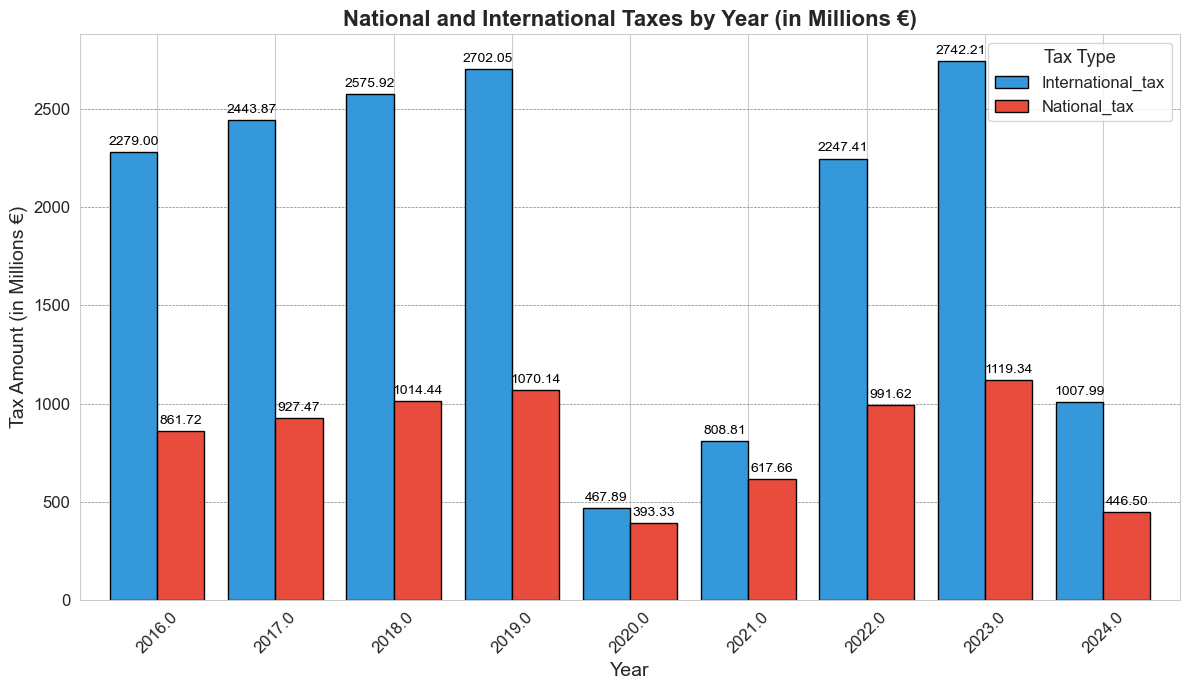

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Define a color palette for the bars
colors = ["#3498db", "#e74c3c"]  # Blue for National Tax, Red for International Tax

# Plotting the bar chart
ax = tax_by_year.plot(kind='bar', 
                      figsize=(12, 7), 
                      color=colors,
                      edgecolor='black',  # Add edge color for a refined look
                      width=0.8)  # Adjust bar width for balance

# Adding title and labels with styling
plt.title('National and International Taxes by Year (in Millions €)', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Tax Amount (in Millions €)', fontsize=14)

# Rotate x-axis labels for better readability and adjust font size
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding data labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3, fmt='%.2f')

# Legend customization
plt.legend(title='Tax Type', fontsize=12, title_fontsize='13')

# Lighter gridlines for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')

# Adjust layout to fit everything nicely
plt.tight_layout()

# Show the plot
plt.show()


In [133]:
spain_flights = combined_airport_traffic_df.loc[combined_airport_traffic_df["STATE_NAME"] == "Spain"]
spain_flights_pivot = pd.pivot_table(spain_flights,index = "YEAR", values = ["FLT_DEP_1","FLT_ARR_1"], aggfunc="sum")/1000

In [134]:
spain_flights_pivot

,FLT_ARR_1,FLT_DEP_1
YEAR,,
2016,927.443,927.670
2017,980.719,980.831
2018,1036.031,1036.001
2019,1058.898,1059.104
2020,447.367,447.505
2021,627.283,627.167
2022,977.094,977.050
2023,1061.570,1061.549
2024,870.262,870.251


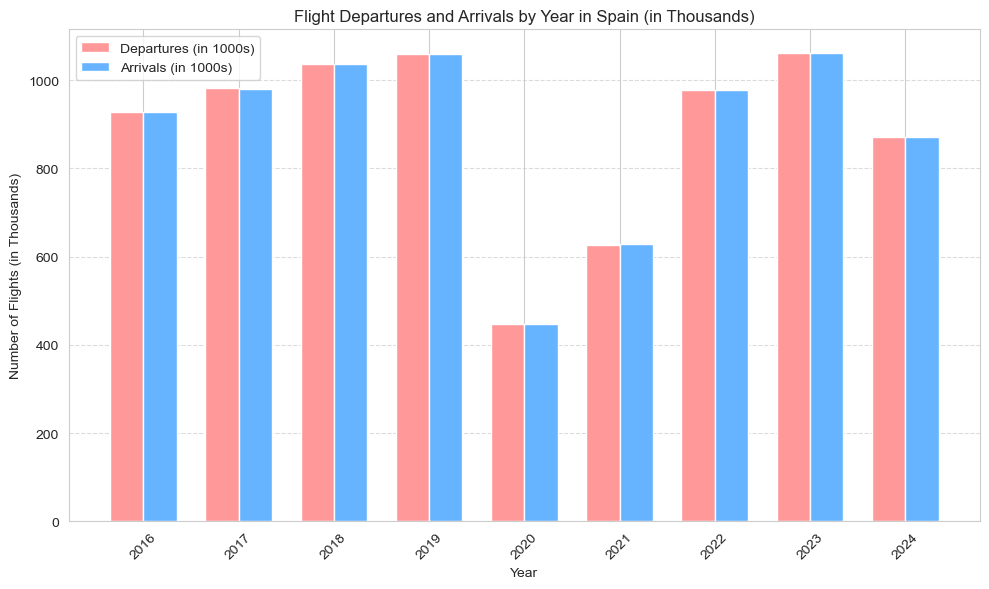

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming combined_airport_traffic_df is already defined and available
spain_flights = combined_airport_traffic_df.loc[combined_airport_traffic_df["STATE_NAME"] == "Spain"]
spain_flights_pivot = (pd.pivot_table(spain_flights, 
                                      index="YEAR", 
                                      values=["FLT_DEP_1", "FLT_ARR_1"], 
                                      aggfunc="sum") / 1000).round(2)

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35  # Width of the bars

# X locations for the groups
years = spain_flights_pivot.index
index = np.arange(len(years))

# Plotting departures and arrivals as separate bar groups
bar1 = ax.bar(index - bar_width / 2, spain_flights_pivot["FLT_DEP_1"], bar_width, label="Departures (in 1000s)", color="#ff9999")
bar2 = ax.bar(index + bar_width / 2, spain_flights_pivot["FLT_ARR_1"], bar_width, label="Arrivals (in 1000s)", color="#66b3ff")

# Adding title and labels
ax.set_title('Flight Departures and Arrivals by Year in Spain (in Thousands)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Flights (in Thousands)')
ax.set_xticks(index)
ax.set_xticklabels(years, rotation=45)  # Rotate x-axis labels for readability
ax.legend()

# Displaying the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines for better readability
plt.show()


In [21]:
spain_flights_pivot

,FLT_ARR_1,FLT_DEP_1
YEAR,,
2016,927.44,927.67
2017,980.72,980.83
2018,1036.03,1036.00
2019,1058.90,1059.10
2020,447.37,447.50
2021,627.28,627.17
2022,977.09,977.05
2023,1061.57,1061.55
2024,870.26,870.25


In [22]:
spain_flights_2024 = spain_flights.loc[spain_flights["YEAR"] == 2024] 
average_daily_flights = pd.pivot_table(spain_flights_2024, index = ["APT_NAME","IATA"], values = "FLT_DEP_1" ,aggfunc="mean").sort_values(by = "FLT_DEP_1", ascending=False ).round(0).head(30)

/var/folders/6g/dhv5ylld76zgp_63c85rplcc0000gn/T/ipykernel_1374/3946926990.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


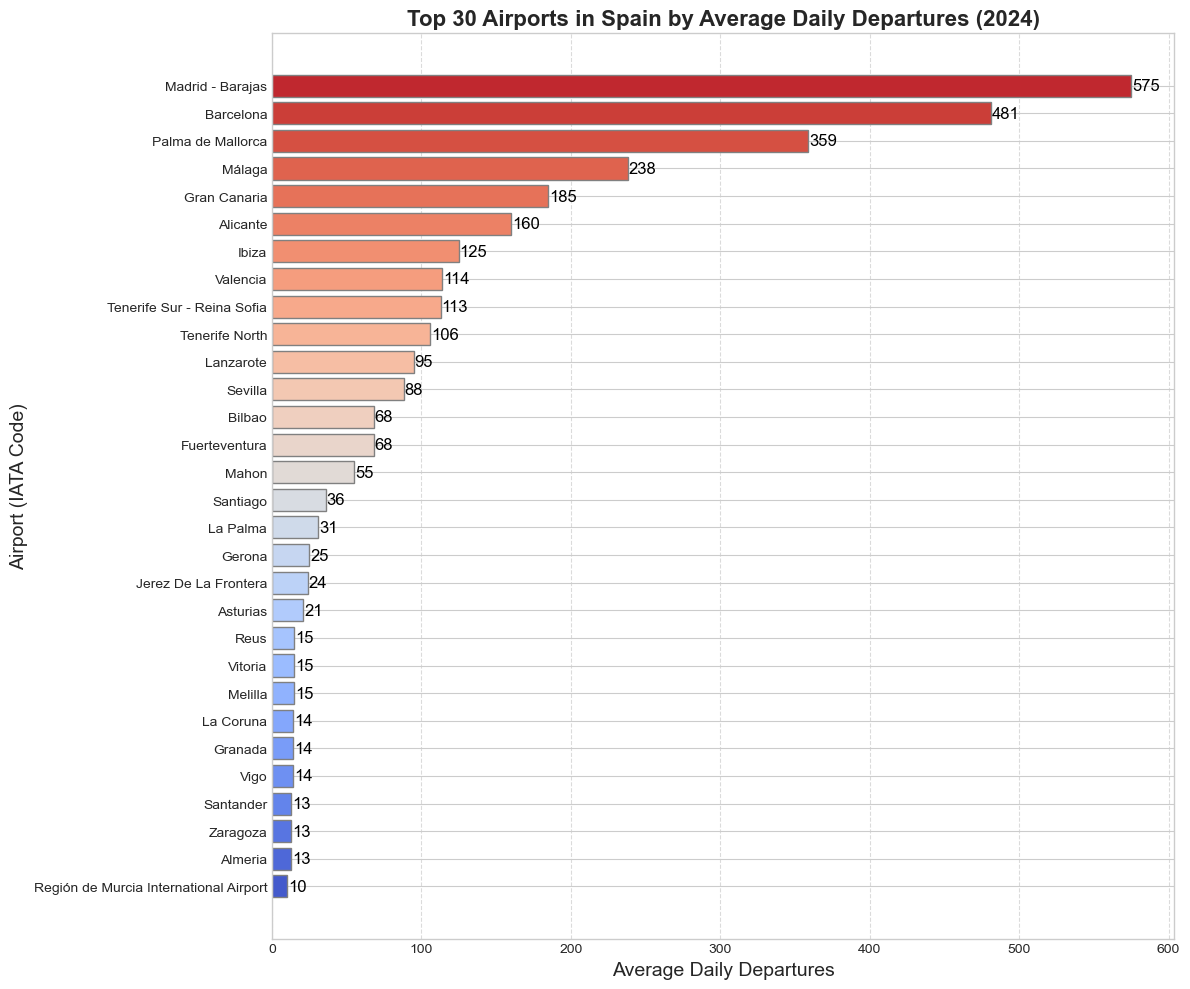

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming spain_flights_2023 is already defined and available
# Create a pivot table of average daily departures by airport, sorted by FLT_DEP_1
average_daily_flights = (
    pd.pivot_table(spain_flights_2024, 
                   index=["APT_NAME", "IATA"], 
                   values="FLT_DEP_1", 
                   aggfunc="mean")
    .sort_values(by="FLT_DEP_1", ascending=False)
    .round(0)
    .head(30)
)

# Set a style and color palette for a more polished look with reversed colors
plt.style.use('seaborn-whitegrid')
colors = sns.color_palette("coolwarm", len(average_daily_flights))[::-1]  # Reversing the color order

# Plotting the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(
    average_daily_flights.index.get_level_values(0), 
    average_daily_flights["FLT_DEP_1"], 
    color=colors, 
    edgecolor='gray'
)

# Adding title and labels with custom font sizes
ax.set_title('Top 30 Airports in Spain by Average Daily Departures (2024)', fontsize=16, weight='bold')
ax.set_xlabel('Average Daily Departures', fontsize=14)
ax.set_ylabel('Airport (IATA Code)', fontsize=14)
ax.invert_yaxis()  # Invert y-axis to display the highest values at the top

# Add gridlines for x-axis for better readability
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Add value labels to each bar
for bar in bars:
    ax.text(
        bar.get_width() + 0.5,  # Position the text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center the text vertically in the bar
        f'{int(bar.get_width())}',  # Display the value as an integer
        va='center', ha='left', fontsize=12, color='black'
    )

# Adjust layout to fit everything neatly
plt.tight_layout()
plt.show()


In [27]:
average_daily_dept_arriv = pd.pivot_table(spain_flights, index = ["APT_NAME","IATA"],columns="YEAR",values = "FLT_TOT_1" ,aggfunc="mean").fillna(0)

In [28]:
# Assuming spain_flights is your original DataFrame with flight data

# Create the pivot table with average daily departures
average_daily_dept_arriv = pd.pivot_table(
    spain_flights,
    index=["APT_NAME", "IATA"],
    columns="YEAR",
    values="FLT_TOT_1",
    aggfunc="mean"
).fillna(0)

# Calculate the YoY difference specifically between 2023 and 2019
if 2023 in average_daily_dept_arriv.columns and 2019 in average_daily_dept_arriv.columns:
    average_daily_dept_arriv['YoY_2023_vs_2019'] = average_daily_dept_arriv[2023] - average_daily_dept_arriv[2019]
else:
    raise ValueError("One or both of the years 2023 and 2019 are not present in the data.")

# Calculate the YoY difference specifically between 2024 and 2019
if 2024 in average_daily_dept_arriv.columns and 2019 in average_daily_dept_arriv.columns:
    average_daily_dept_arriv['YoY_2024_vs_2019'] = average_daily_dept_arriv[2024] - average_daily_dept_arriv[2019]
else:
    raise ValueError("One or both of the years 2024 and 2019 are not present in the data.")

# Calculate the YoY difference specifically between 2024 and 2020
if 2024 in average_daily_dept_arriv.columns and 2020 in average_daily_dept_arriv.columns:
    average_daily_dept_arriv['YoY_2024_vs_2020'] = average_daily_dept_arriv[2024] - average_daily_dept_arriv[2020]
else:
    raise ValueError("One or both of the years 2024 and 2020 are not present in the data.")

# Reset index to convert index levels back to columns
average_daily_dept_arriv.reset_index(inplace=True)

# Select only the desired columns
result_columns = ["APT_NAME", "IATA", 2024, "YoY_2024_vs_2019"]
average_daily_dept_arriv_selected = average_daily_dept_arriv[result_columns]

state_traffic = average_daily_dept_arriv_selected.round(0).sort_values(by = 2024, ascending=False)



In [128]:
import pandas as pd
import plotly.graph_objects as go

# Assuming spain_flights is your original DataFrame with flight data

# Create the pivot table with average daily departures
average_daily_dept_arriv = pd.pivot_table(
    spain_flights,
    index=["APT_NAME", "IATA"],
    columns="YEAR",
    values="FLT_TOT_1",
    aggfunc="mean"
).fillna(0)

# Calculate the YoY difference specifically between 2024 and 2019
if 2024 in average_daily_dept_arriv.columns and 2019 in average_daily_dept_arriv.columns:
    average_daily_dept_arriv['YoY_2024_vs_2019'] = average_daily_dept_arriv[2024] - average_daily_dept_arriv[2019]
else:
    raise ValueError("One or both of the years 2024 and 2019 are not present in the data.")

# Reset index to convert index levels back to columns
average_daily_dept_arriv.reset_index(inplace=True)

# Select only the desired columns
result_columns = ["APT_NAME", "IATA", 2024, "YoY_2024_vs_2019"]
average_daily_dept_arriv_selected = average_daily_dept_arriv[result_columns]

# Sort by the Mean Departures 2024 in descending order
average_daily_dept_arriv_selected.sort_values(by=2024, ascending=False, inplace=True)

# Create the visual table
fig = go.Figure(data=[go.Table(
    header=dict(values=["Airport Name", "IATA Code", "Mean Flights(D/A) 2024", "YoY 2024 vs 2019"],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(
        values=[
            average_daily_dept_arriv_selected['APT_NAME'],
            average_daily_dept_arriv_selected['IATA'],
            average_daily_dept_arriv_selected[2024].round(0),
            average_daily_dept_arriv_selected['YoY_2024_vs_2019'].round(0)
        ],
        # Set default color for all cells and then override only the YoY column
        fill_color=[
            ['paleturquoise'] * len(average_daily_dept_arriv_selected),  # Default color for APT_NAME
            ['paleturquoise'] * len(average_daily_dept_arriv_selected),  # Default color for IATA
            ['paleturquoise'] * len(average_daily_dept_arriv_selected),  # Default color for Mean Departures 2024
            ['green' if x > 0 else 'red' for x in average_daily_dept_arriv_selected['YoY_2024_vs_2019']]  # Color for YoY column
        ],
        align='left'
    ))
])

fig.update_layout(title='Airport Flight Data: 2024 vs 2019', height=400)
fig.show()


/var/folders/6g/dhv5ylld76zgp_63c85rplcc0000gn/T/ipykernel_1374/680654401.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
spain_passangers_type_iata["Total_Tax"] = spain_passangers_type_iata["National_tax"] + spain_passangers_type_iata["International_tax"]

In [31]:
spain_passangers_type_iata.loc[
    spain_passangers_type_iata["Origin"].isin(["Madrid-B"])
]

,Origin,Month_Year,D,I,YEAR,YEAR_MONTH,APT_NAME,IATA,Airport,YR,Security (National),Security(International),National_tax,International_tax,Total_Tax
0,Alicante,2016-01,0.0,7968.0,2016.0,2016-01,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,112109.76,112109.76
31,Alicante,2016-02,0.0,6813.0,2016.0,2016-02,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,95858.91,95858.91
60,Alicante,2016-03,0.0,8203.0,2016.0,2016-03,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,115416.21,115416.21
91,Alicante,2016-04,0.0,7747.0,2016.0,2016-04,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,109000.29,109000.29
121,Alicante,2016-05,0.0,8577.0,2016.0,2016-05,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,120678.39,120678.39


In [45]:
spain_airport = ((pd.pivot_table(spain_passangers_type_iata, index = ["Origin","IATA","YEAR"],values ="Total_Tax",aggfunc="sum")/10000).fillna(0).round(0)).reset_index()

In [43]:
main_airports = spain_passangers_type_iata.loc[spain_passangers_type_iata["Origin"].isin(["Madrid - Barajas","Barcelona"])]

In [48]:
main_airports_data = ((pd.pivot_table(main_airports, index = ["Origin","IATA","YEAR"],values ="Total_Tax",aggfunc="sum")/10000).fillna(0).round(0)).reset_index()

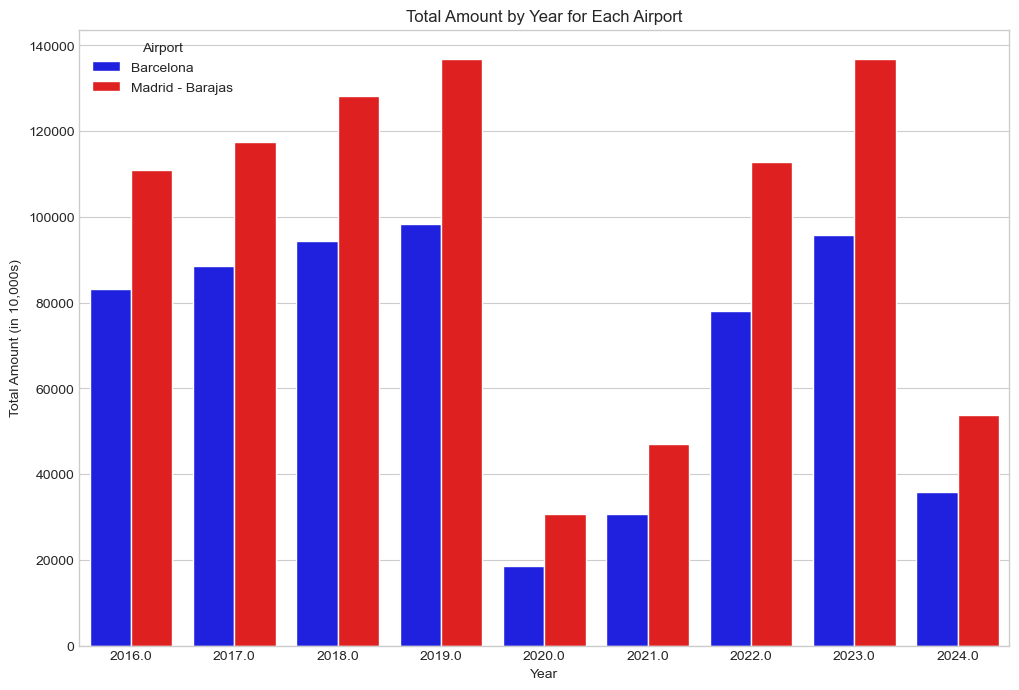

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouping by "YEAR" and "Origin" to get total amount for each airport per year
total_by_year_airport = main_airports_data.groupby(['YEAR', 'Origin'])['Total_Tax'].sum().reset_index()

# Set up the plot
plt.figure(figsize=(12, 8))

# Custom color palette for two colors (blue and red)
colors = ['blue', 'red']
sns.barplot(data=total_by_year_airport, x='YEAR', y='Total_Tax', hue='Origin', palette=colors)

# Adding title and labels
plt.title('Total Amount by Year for Each Airport')
plt.xlabel('Year')
plt.ylabel('Total Amount (in 10,000s)')

# Display the legend and the plot
plt.legend(title='Airport')
plt.show()


In [119]:
aena = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Project/Project1/aena3.0.csv")


In [120]:
aena

,P/L,2019,2020,2021,2022,2023
0,Total Revenue,4457.77,2185.90,2333.12,4197.15,5055.19
1,Gross Profit,3831.06,1575.04,1714.84,3519.53,4010.69
2,Operating Profit,1947.02,-24.13,26.56,1283.79,1986.13
3,Earnings Before Taxes,1882.85,-213.00,-168.00,1169.61,2165.89
4,Net Income,1442.02,-127.00,-60.04,901.00,1630.81


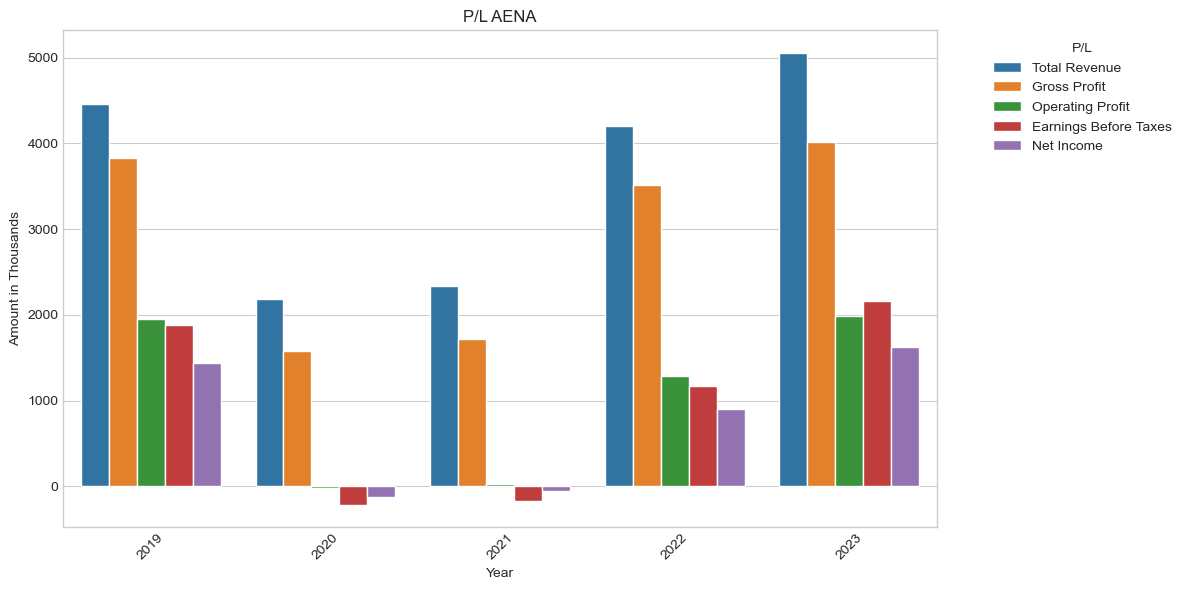

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

aena_long = aena.melt(id_vars='P/L', var_name='Year', value_name='Amount')

aena_long = aena.melt(id_vars='P/L', var_name='Year', value_name='Amount')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=aena_long, x='Year', y='Amount', hue='P/L', dodge=True)

plt.xlabel('Year')
plt.ylabel('Amount in Thousands')
plt.title('P/L AENA')
plt.legend(title='P/L', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [129]:
spain_passangers_type_iata.head()

,Origin,Month_Year,D,I,YEAR,YEAR_MONTH,APT_NAME,IATA,Airport,YR,Security (National),Security(International),National_tax,International_tax,Total_Tax
0,Alicante,2016-01,0.0,7968.0,2016.0,2016-01,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,112109.76,112109.76
31,Alicante,2016-02,0.0,6813.0,2016.0,2016-02,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,95858.91,95858.91
60,Alicante,2016-03,0.0,8203.0,2016.0,2016-03,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,115416.21,115416.21
91,Alicante,2016-04,0.0,7747.0,2016.0,2016-04,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,109000.29,109000.29
121,Alicante,2016-05,0.0,8577.0,2016.0,2016-05,Alicante,ALC,Alicante-Elche,6.15,5.27,7.92,0.0,120678.39,120678.39
